# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

**Exercise sheet 9**

## Running code on the compute cluster: lattice scalar field

**Goal**: Learn how to scale up simulations by transitioning from running them in the notebook to stand-alone scripts on the compute cluster.

In lecture 7 we implemented the Metropolis-Hastings simulation of a lattice scalar field using the following code:

```Python
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

def potential_v(x,lamb):
    '''Compute the potential function V(x).'''
    return lamb*(x*x-1)*(x*x-1)+x*x

def neighbor_sum(phi,s):
    '''Compute the sum of the state phi on all 8 neighbors of the site s.'''
    w = len(phi)
    return (phi[(s[0]+1)%w,s[1],s[2],s[3]] + phi[(s[0]-1)%w,s[1],s[2],s[3]] +
            phi[s[0],(s[1]+1)%w,s[2],s[3]] + phi[s[0],(s[1]-1)%w,s[2],s[3]] +
            phi[s[0],s[1],(s[2]+1)%w,s[3]] + phi[s[0],s[1],(s[2]-1)%w,s[3]] +
            phi[s[0],s[1],s[2],(s[3]+1)%w] + phi[s[0],s[1],s[2],(s[3]-1)%w] )

def scalar_action_diff(phi,site,newphi,lamb,kappa):
    '''Compute the change in the action when phi[site] is changed to newphi.'''
    return (2 * kappa * neighbor_sum(phi,site) * (phi[site] - newphi) +
            potential_v(newphi,lamb) - potential_v(phi[site],lamb) )

def scalar_MH_step(phi,lamb,kappa,delta):
    '''Perform Metropolis-Hastings update on state phi with range delta.'''
    site = tuple(rng.integers(0,len(phi),4))
    newphi = phi[site] + rng.uniform(-delta,delta)
    deltaS = scalar_action_diff(phi,site,newphi,lamb,kappa)
    if deltaS < 0 or rng.uniform() < np.exp(-deltaS):
        phi[site] = newphi
        return True
    return False

def run_scalar_MH(phi,lamb,kappa,delta,n):
    '''Perform n Metropolis-Hastings updates on state phi and return number of accepted transtions.'''
    total_accept = 0
    for _ in range(n):
        total_accept += scalar_MH_step(phi,lamb,kappa,delta)
    return total_accept

def batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each.
    Returns the mean and standard error.'''
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

lamb = 1.5
kappas = np.linspace(0.08,0.18,11)
width = 3
num_sites = width**4
delta = 1.5  # chosen to have ~ 50% acceptance
equil_sweeps = 1000
measure_sweeps = 2
measurements = 2000

mean_magn = []
for kappa in kappas:
    phi_state = np.zeros((width,width,width,width))
    run_scalar_MH(phi_state,lamb,kappa,delta,equil_sweeps * num_sites)
    magnetizations = np.empty(measurements)
    for i in range(measurements):
        run_scalar_MH(phi_state,lamb,kappa,delta,measure_sweeps * num_sites)
        magnetizations[i] = np.mean(phi_state)
    mean, err = batch_estimate(np.abs(magnetizations),lambda x:np.mean(x),10)
    mean_magn.append([mean,err])
    
plt.errorbar(kappas,[m[0] for m in mean_magn],yerr=[m[1] for m in mean_magn],fmt='-o')
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$|m|$")
plt.title(r"Absolute field average on $3^4$ lattice, $\lambda = 1.5$")
plt.show()
```
The goal will be to reproduce and extend its output.

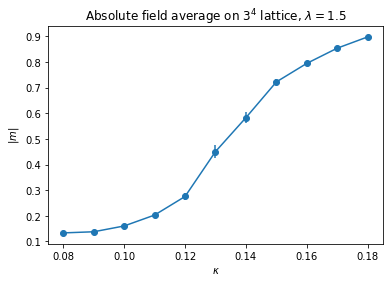

**(a)** Turn the simulation into a standalone script `latticescalar.py` (similar to `ising.py`) that takes the relevant parameters e.g.
```bash
$ python3 latticescalar.py -l 1.5 -k 0.12 -w 3 -n 1000
```
for $\lambda=1.5$, $\kappa=0.12$, $w=3$, and $1000$ measurements, together with optional parameters $\delta$ and numbers of sweeps, as command line arguments and stores the relevant simulation outcomes in an hdf5-file. **(40 pts)**

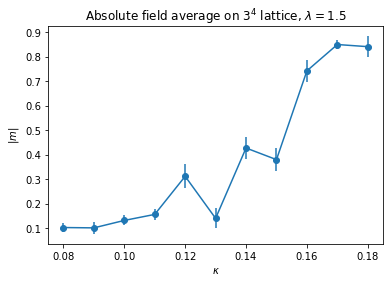

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

# Load data
output_filename = "preliminary_simulation.h5"
with h5py.File(output_filename,'r') as f:
    handler = f["mean-magn"]
    mean_magn = np.array(handler)
    kappas = handler.attrs["kappas"]

# Plotterdeplotterdeplot
plt.figure()
plt.errorbar(kappas,[m[0] for m in mean_magn],yerr=[m[1] for m in mean_magn],fmt='-o')
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$|m|$")
plt.title(r"Absolute field average on $3^4$ lattice, $\lambda = 1.5$")
plt.show()

**(b)** Write a bash script `job_latticescalar.sh` that submits an array job to the cluster for $w=3$ and $2000$ measurements and $\lambda = 1.0, 1.5, 2.0$ and $\kappa = 0.08, 0.09, ..., 0.18$ (so 33 simulations in total). Submit the job to the `hefstud` slurm partition (do not run all 33 in parallel). **(30 pts)**

**(c)** Load the stored data into this notebook and reproduce the plot above (with $\lambda = 1$ and $\lambda=2$ added). **(30 pts)**